# <font size="7"> **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [26]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 5

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


In [27]:
n_train = int(0.7 * len(X_full))

X_train = X_full[:n_train]
y_train = y_full[:n_train]

X_val = X_full[n_train:]
y_val = y_full[n_train:]

print(f"✓ Training Set: {X_train.shape[0]} samples")
print(f"✓ Validation Set: {X_val.shape[0]} samples")

✓ Training Set: 2100 samples
✓ Validation Set: 900 samples


In [28]:
W1 = torch.randn(2, 16) * 0.1; W1.requires_grad_()
b1 = torch.zeros(1, 16);       b1.requires_grad_()

W2 = torch.randn(16, 16) * 0.1; W2.requires_grad_()
b2 = torch.zeros(1, 16);        b2.requires_grad_()

W3 = torch.randn(16, 16) * 0.1; W3.requires_grad_()
b3 = torch.zeros(1, 16);        b3.requires_grad_()

W4 = torch.randn(16, 1) * 0.1;  W4.requires_grad_()
b4 = torch.zeros(1, 1);         b4.requires_grad_()


print("✓ Neural Network Initialized")
print(f"  Architecture: 2 -> 16 -> 16 -> 16 -> 1")
total_params = W1.numel() + b1.numel() + W2.numel() + b2.numel() + W3.numel() + b3.numel() + W4.numel() + b4.numel()
print(f"  Total Parameters: {total_params}")


✓ Neural Network Initialized
  Architecture: 2 -> 16 -> 16 -> 16 -> 1
  Total Parameters: 609


In [29]:
def relu(x):
    """ReLU Activation: max(0, x)"""
    return torch.clamp(x, min=0)

def sigmoid(x):
    """Sigmoid Activation: 1 / (1 + exp(-x))"""
    return 1 / (1 + torch.exp(-x))

print("✓ Activation Functions Defined")
print("  Hidden Layers: ReLU")
print("  Output Layer: Sigmoid")


✓ Activation Functions Defined
  Hidden Layers: ReLU
  Output Layer: Sigmoid


In [30]:
def forward_pass(X):
    """
    Forward propagation through the network
    Uses manual matrix multiplication (torch.matmul)
    """
    # Layer 1: Input -> Hidden1
    z1 = torch.matmul(X, W1) + b1
    a1 = relu(z1)

    # Layer 2: Hidden1 -> Hidden2
    z2 = torch.matmul(a1, W2) + b2
    a2 = relu(z2)

    # Layer 3: Hidden2 -> Hidden3
    z3 = torch.matmul(a2, W3) + b3
    a3 = relu(z3)

    # Output Layer: Hidden3 -> Output
    z4 = torch.matmul(a3, W4) + b4
    output = sigmoid(z4)

    return output

print("✓ Forward Pass Implemented")
print("  Method: Manual torch.matmul()")
print("  No torch.nn modules used")


✓ Forward Pass Implemented
  Method: Manual torch.matmul()
  No torch.nn modules used


In [31]:
def binary_cross_entropy(y_pred, y_true):
    """
    Manual BCE Loss Implementation
    Formula: Loss = -1/N * Σ[y*log(ŷ) + (1-y)*log(1-ŷ)]
    """
    # Clamp predictions to avoid log(0) - numerical stability
    y_pred_clamped = torch.clamp(y_pred, min=1e-7, max=1-1e-7)

    # Calculate BCE manually
    loss = -(y_true * torch.log(y_pred_clamped) +
             (1 - y_true) * torch.log(1 - y_pred_clamped))

    return loss.mean()

print("✓ Binary Cross Entropy Loss Implemented")
print("  Formula: -1/N * Σ[y*log(ŷ) + (1-y)*log(1-ŷ)]")
print("  Numerical Stability: torch.clamp() applied")


✓ Binary Cross Entropy Loss Implemented
  Formula: -1/N * Σ[y*log(ŷ) + (1-y)*log(1-ŷ)]
  Numerical Stability: torch.clamp() applied


In [32]:
def calculate_accuracy(y_pred, y_true):
    """
    Calculate classification accuracy
    Threshold: 0.5
    """
    predictions = (y_pred >= 0.5).float()
    correct = (predictions == y_true).float().sum()
    accuracy = correct / y_true.shape[0]
    return accuracy.item()

print("✓ Accuracy Function Defined")
print("  Decision Threshold: 0.5")


✓ Accuracy Function Defined
  Decision Threshold: 0.5


In [33]:
import matplotlib.pyplot as plt

# Hyperparameters
learning_rate = 0.01
epochs = 500
batch_size = 32

# Metrics storage
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# List of all parameters for easy iteration
params = [W1, b1, W2, b2, W3, b3, W4, b4]

print("="*60)
print("TRAINING INITIATED - EXCLUSION ZONE PROTOCOL")
print("="*60)
print(f"Learning Rate: {learning_rate}")
print(f"Epochs: {epochs}")
print(f"Batch Size: {batch_size}")
print("="*60)

for epoch in range(epochs):
    # ========== TRAINING PHASE ==========
    perm = torch.randperm(X_train.shape[0])
    X_train_shuffled = X_train[perm]
    y_train_shuffled = y_train[perm]

    epoch_train_loss = 0.0
    epoch_train_acc = 0.0
    n_batches = 0

    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train_shuffled[i:i+batch_size]
        y_batch = y_train_shuffled[i:i+batch_size]

        # Forward pass
        y_pred = forward_pass(X_batch)

        # Calculate loss
        loss = binary_cross_entropy(y_pred, y_batch)

        # Backward pass
        loss.backward()

        # Manual weight update (SGD)
        with torch.no_grad():
            for param in params:
                if param.grad is not None:
                    param -= learning_rate * param.grad
                    param.grad.zero_()

        epoch_train_loss += loss.item()
        epoch_train_acc += calculate_accuracy(y_pred.detach(), y_batch)
        n_batches += 1

    avg_train_loss = epoch_train_loss / n_batches
    avg_train_acc = epoch_train_acc / n_batches

    # ========== VALIDATION PHASE ==========
    with torch.no_grad():
        y_val_pred = forward_pass(X_val)
        val_loss = binary_cross_entropy(y_val_pred, y_val).item()
        val_acc = calculate_accuracy(y_val_pred, y_val)

    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(avg_train_acc)
    val_accuracies.append(val_acc)

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1:3d}/{epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

print("="*60)
print("TRAINING COMPLETE")
print("="*60)
print(f"Final Training Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

TRAINING INITIATED - EXCLUSION ZONE PROTOCOL
Learning Rate: 0.01
Epochs: 500
Batch Size: 32
Epoch [ 50/500] | Train Loss: 0.6651 | Train Acc: 0.6080 | Val Loss: 0.6681 | Val Acc: 0.6022
Epoch [100/500] | Train Loss: 0.5897 | Train Acc: 0.6027 | Val Loss: 0.5921 | Val Acc: 0.6011
Epoch [150/500] | Train Loss: 0.4687 | Train Acc: 0.7886 | Val Loss: 0.4731 | Val Acc: 0.7978
Epoch [200/500] | Train Loss: 0.4562 | Train Acc: 0.8011 | Val Loss: 0.4654 | Val Acc: 0.7967
Epoch [250/500] | Train Loss: 0.4454 | Train Acc: 0.8068 | Val Loss: 0.4531 | Val Acc: 0.8056
Epoch [300/500] | Train Loss: 0.3624 | Train Acc: 0.8841 | Val Loss: 0.3734 | Val Acc: 0.8689
Epoch [350/500] | Train Loss: 0.2939 | Train Acc: 0.9234 | Val Loss: 0.3092 | Val Acc: 0.9111
Epoch [400/500] | Train Loss: 0.2796 | Train Acc: 0.9276 | Val Loss: 0.2932 | Val Acc: 0.9200
Epoch [450/500] | Train Loss: 0.2691 | Train Acc: 0.9299 | Val Loss: 0.2893 | Val Acc: 0.9167
Epoch [500/500] | Train Loss: 0.2634 | Train Acc: 0.9337 | Val

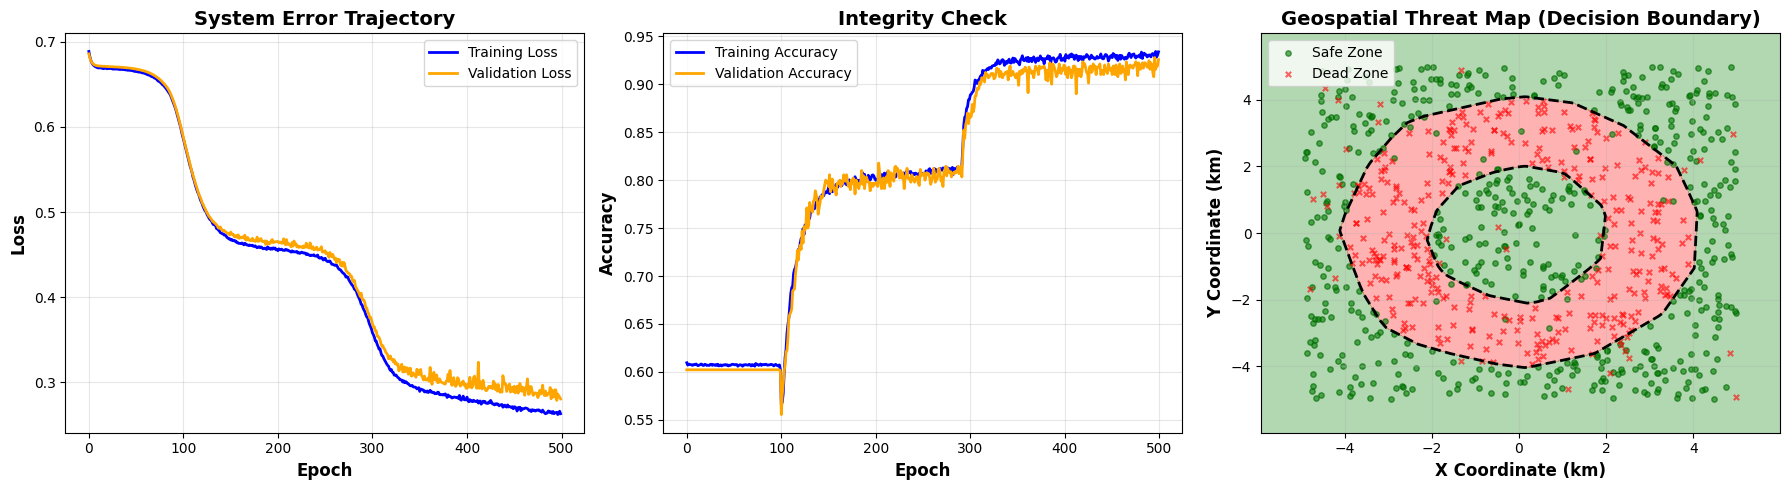


GDC DASHBOARD GENERATED
✓ Panel 1: System Error Trajectory - VERIFIED
✓ Panel 2: Integrity Check - VERIFIED
✓ Panel 3: Geospatial Threat Map - VERIFIED

✓ Dashboard saved as 'gdc_dashboard.png'
✓ Mission Parameters Verified
✓ System Ready for Deployment to Kepler-186f


In [34]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ========== PANEL 1: SYSTEM ERROR TRAJECTORY (Loss Plot) ==========
axes[0].plot(train_losses, label='Training Loss', color='blue', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', color='orange', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0].set_title('System Error Trajectory', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# ========== PANEL 2: INTEGRITY CHECK (Accuracy Plot) ==========
axes[1].plot(train_accuracies, label='Training Accuracy', color='blue', linewidth=2)
axes[1].plot(val_accuracies, label='Validation Accuracy', color='orange', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[1].set_title('Integrity Check', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# ========== PANEL 3: GEOSPATIAL THREAT MAP (Decision Boundary) ==========
# Create mesh grid for decision boundary
x_min, x_max = X_val[:, 0].min() - 1, X_val[:, 0].max() + 1
y_min, y_max = X_val[:, 1].min() - 1, X_val[:, 1].max() + 1

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Predict on mesh grid
grid_points = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
with torch.no_grad():
    Z = forward_pass(grid_points).numpy()
Z = Z.reshape(xx.shape)

# Plot decision boundary
axes[2].contourf(xx, yy, Z, levels=[0, 0.5, 1],
                 colors=['green', 'red'], alpha=0.3)
axes[2].contour(xx, yy, Z, levels=[0.5],
                colors='black', linewidths=2, linestyles='dashed')

# Plot validation points
X_val_np = X_val.numpy()
y_val_np = y_val.numpy().flatten()

safe_mask = y_val_np == 0
dead_mask = y_val_np == 1

axes[2].scatter(X_val_np[safe_mask, 0], X_val_np[safe_mask, 1],
                c='green', marker='o', s=15, alpha=0.6,
                edgecolors='darkgreen', label='Safe Zone')
axes[2].scatter(X_val_np[dead_mask, 0], X_val_np[dead_mask, 1],
                c='red', marker='x', s=15, alpha=0.6,
                linewidths=1.5, label='Dead Zone')

axes[2].set_xlabel('X Coordinate (km)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Y Coordinate (km)', fontsize=12, fontweight='bold')
axes[2].set_title('Geospatial Threat Map (Decision Boundary)',
                  fontsize=14, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gdc_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("GDC DASHBOARD GENERATED")
print("="*60)
print("✓ Panel 1: System Error Trajectory - VERIFIED")
print("✓ Panel 2: Integrity Check - VERIFIED")
print("✓ Panel 3: Geospatial Threat Map - VERIFIED")
print("\n✓ Dashboard saved as 'gdc_dashboard.png'")
print("✓ Mission Parameters Verified")
print("✓ System Ready for Deployment to Kepler-186f")
print("="*60)

In [35]:
# ==============================================================================
# Code from here. Best of luckk :)
# ==============================================================================